Marras Antoine 1A CentraleSupélec: P2022

# MINI-PROJET FENICS: Modélisation à l'aide d'équations elliptiques
## Un cas particulier des équation de helmoltz: l'équation de Scorer

#### Introduction:

Lorsqu'un vent de direction constante soufle dans une plaine et rencontre une montagne, on remarque souvent des nuages aux formes particulières en aval tels que des nuages lenticulaires.[meriem chekroum]
D'autres phénomènes similaires tels que des courants ascendants violents en aval des montagnes sont observés par les aviateurs.

L'équation de Scorer modélise de telles ondes de gravité en aval des montagnes, aussi nommées __onde de Lee__, ou __onde orographiques__

## Modélisation physique:

Dans le plan ($\vec{x}$, $\vec{z}$.) on notera w(x,z) la vitesse verticale du vent en (x,z), $u_0(z)$ vitesse horizontale initiale du vent.

On se placera dans l'approximation de Boussinesq. (hypothèse d'incompressibilité. (variation de température négligées)).

le domaine est un rectangle dont la base est remplacée par un profil de montagne de hauteur $h(x)$. Aux bords, on a $w = u_0\frac{d h}{dx}$ (au contact de la montagne, conservation de la quantité de mouvement), et nul sur les autres bords.

En utilisant la conservation de la quantité de mouvement, de la masse et de l'énergie dans l'approximation de Boussinesq appliquée aux équations de Navier-Stokes, on a:

$\Delta w(x,z) + l(z)² w(x,z) = 0$ avec $l(z)² = \frac{N²}{u_0²} - \frac{1}{u_0} \frac{d² u_0}{dz²} $ paramètre de Scorer

et $N=\sqrt{\frac{g}{\theta} \frac{d \theta}{d z}} $ fréquence de Brunt-Väisälä, environs $0,012 s^{−1}$ dans l'atmosphère.

## Modélisation mathématique:

### Adimensionnement:

Reprenons l'équation précédente $\Delta_x w + l² w = 0$. Elle est bien elliptique (en appliquant $b² - 4ac$, on trouve -4 < 0)

| Quantité | Unité |  Quantités adimensionnée |
|:--------:|:-----:|:------------------------:|
|    $w$   |  $W$  |        $w = W w^*$       |
|   $x,z$  |  $L$  | $x = Lx^* , z = L z^*$   |


En précisant les dépendances spatiales du laplacien, on a $\Delta_x = \frac{1}{L²} \Delta_{x^*} $

On a $\frac{W}{L²} \Delta_{x^*} w^* + l² W w^* = 0$,
qui devient
$\Delta_{x^*} w^* + (\frac{l}{k})²w^* = 0$ en introduisant $k=\frac{1}{l}$, en $L^{-1}$

Par la suite, on retirera les * par soucis de clareté.

### Domaine
Le domaine est physiquement un rectangle de largeur b, de longeur 2a dont la base est remplacée par un profil de montagne. Ici, on choisira une sorcière d'Agnesi, d'équation $h(x) = \frac{\gamma³}{\gamma² + x²}$ (sommet de hauteur $\gamma$).
Le domaine est donc $\Omega =\{(x,z)\in ]-a,a[\times ]0,b[ \; | \; z> h(x)\}$


### Conditions aux bords
On a les conditions aux bords: $\forall (x,y) \in \partial \Omega$

\begin{equation}
  w(x,z)=\begin{cases}
    0, & \text{si $x=-a$ ou $x=a$ ou $z =b$ }.\\
    u_0 \frac{dh}{dx}, & \text{sinon}.
  \end{cases}
\end{equation}

### Relèvement
On relève les conditions aux bords en posant $w = \tilde{w} + w_0$ avec $w_0$ une solution particulière répondant aux conditions aux bords précédentes.

### Formulation variationnelle

On choisit $v\in \mathcal{D}(\Omega)$ et en supposant $\tilde{w} \in H¹_0(\Omega)$, on obtient la formulation faible suivante:
$\int_{\Omega}{l² \tilde{w} v -  \nabla{\tilde{w}} \nabla{v}} = \int_{\Omega}{\nabla{w_0} \nabla{v} - l² w_0 v}$



## Simulations

Notes: Pour obtenir un profil de sorcière d'agnesi, <span style="color:red"> j'ai utilisé le logiciel gmsh, couplé à dolphin-converter </span> pour générer paramétriquement un mesh du domaine au dessus de la montagne.
<span style="color:red">Le script de génération de mesh est disponible en annexe.</span>

### Imports:

In [3]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as pyplot
from mshr import *
import dolfin as fn

### Paramètres de la montagne D'Agnesi:

In [84]:
gamma = 1000     # paramètre de hauteur de la montagne
height = 1.0    # coefficient multiplicateur pour rendre plus abrubte la montagne
R = 10000.0        # ordonnée du bord supérieur du domaine.
u_0 = 4.4       # vent horizontal initial ici supposé uniforme
Larg = 10000       # largeur medium montagne (larg-Sommet-larg)
epsi = 10**-6   # precision demandée pour éviter les erreurs d'égalité de flottants

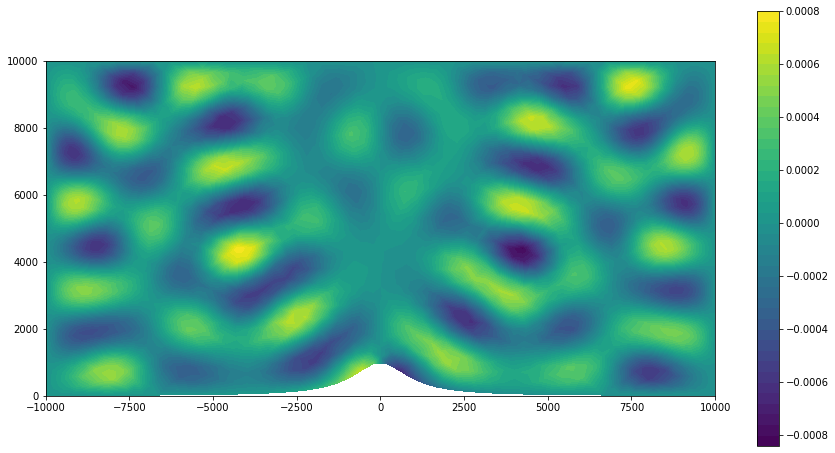

In [86]:

# Import du mesh du doa
mesh = fn.Mesh('generated_mesh.xml') # fn.Mesh('inv.xml')
markers = fn.MeshFunction("size_t", mesh, 'generated_mesh_physical_region.xml')
dx = fn.Measure('dx', domain=mesh, subdomain_data=markers)
V = FunctionSpace(mesh, 'P', 1)

# -----------------------------------------------------------------------------------------------------------------

# Conditions aux bords
# Nullité sur tout le bord, sauf sur la montagne
# on prend la formule de la pente de la montagne, calculable grâce à la formule explicite de la sorcière d'Agnesi
u_D = Expression('abs(x[0]-Larg)<epsi or abs(x[0]+Larg)<epsi? 0:   x[1]>gamma*height? 0 : -2*height*gamma*gamma*x[0]/(pow( (x[0]*x[0]+ gamma*gamma) ,2))',
                 degree = 6,
                 gamma = gamma, height=height, epsi = epsi, Larg=Larg)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)
# -----------------------------------------------------------------------------------------------------------------

# Problème variationnel
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)
cte = Constant(0.002727) #vitesse horizontale ~ 4.4m/s, et fréquence N ~ 0.012s-1 -> 0.002727 ?
a = - dot(grad(u), grad(v))*dx + cte*cte*u*v*dx
L = f*v*dx # 0
# -----------------------------------------------------------------------------------------------------------------

# Calcul de la solution
u = Function(V)
solve(a == L, u, bc)
# -----------------------------------------------------------------------------------------------------------------

# Affichage
plt.rcParams['figure.figsize'] = [15, 8]
# plot(mesh) # affichage du mesh sur la figure (peut être commenté)
p = plot(u)
pyplot.colorbar(p)# ajout d'une barre colorée

plt.show()


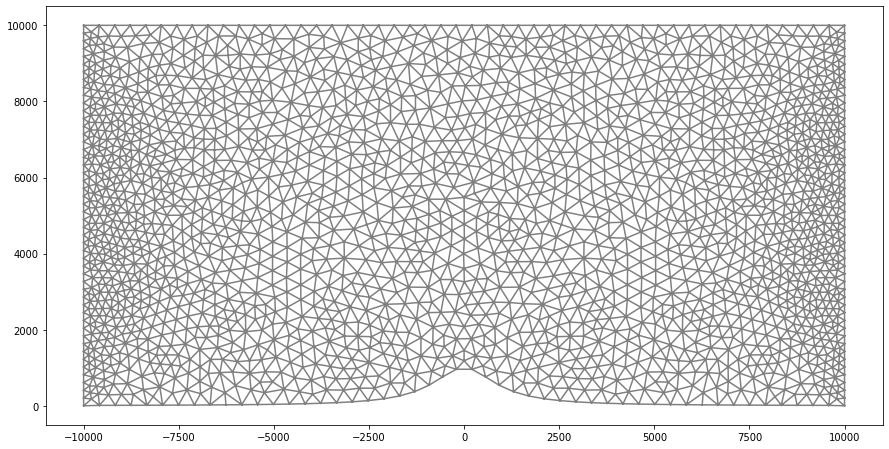

In [87]:
plot(mesh)
plt.show()

## Descriptions de simulations 10 lignes

## 15 lignes maximum de conclusion sur l’utilité de ces simulations en insistant sur laprise en compte du caractère aléatoire,

# Sources:

__onde orographique et nuages lenticulaires__: Meriem Chakroun. La variabilité des nuages et son rôle sur le climat en Europe : télédétection
et simulation régionale. Océan, Atmosphère. Université Paris-Saclay, 2016. Français. �NNT :
2016SACLV067�. �tel-01599247�: page 10.

Encyclopedia of Atmospheric Sciences, 2003, Holton, J.R., J. Pyle and J.A. Curry,eds., Elsevier Science Ltd. pp. 1161-1169

__Conditions aux limites__: Theory of airflow over mountains : I11 - Airstream characteristicsBy R. S. SCORER Imperial College, London

__utilisation de Fenics, Gmsh et dolphin-converter__: https://comphysblog.wordpress.com/2018/08/15/fenics-2d-electrostatics-with-imported-mesh-and-boundaries/




## Annexe

Template de code GMH. Il faut ajouter un .format() pour remplacer les valeurs importantes


In [85]:
import os

template = """
ls = 5;
nombre_points_courbe = {0};
ratio = 1000.0; // pour convertir les mètres en kilomètres

L = {1}; // um
R = {2};   // hauteur du bord supérieur du domaine
a = {3};
h = {4};
Point(1) = {{-L, R, 0, ls}};
Point(2) = {{-L, 0, 0, ls}};
Point(3) = {{L, 0, 0, ls}};
Point(4) = {{L, R, 0, ls}};

Line(1) = {{1, 2}};
Line(2) = {{3, 4}};
Line(3) = {{4, 1}};

pList[0] = 2; // First point label
nPoints = nombre_points_courbe; // Nombre de points de discretisation pour la sorcière
For i In {{1 : nPoints}}
	x =-L + 2*L*i/(nPoints + 1);
	pList[i] = newp;
	Point(pList[i]) = {{x, (  h * (a * a * a)/(x*x + a*a) ) , 0, ls}};
EndFor
pList[nPoints+1] = 3; // Last point label (top-left point of the outlet region)

Spline(6) = pList[];
Line Loop(7) = {{1,6,2,3}};
Plane Surface(7) = {{7}};
Physical Surface("surf") = {{7}};
Transfinite Line {{6, 1, 3, 2}} = 50 Using Progression 1;

"""
print(script_msh)

script_msh = template.format(100, Larg, R, gamma, height) # nombre point courbe, L, R, a, h

with open("script.geo", "w+", encoding = "utf-8") as f:
    for ligne in script_msh:
        f.write(ligne)

# generate msh file
print("meshing...")
stream = os.popen("gmsh script.geo -2 -o ./generated_mesh.msh")
out = stream.read()
print(out)

print("convertion to xml")
# generate xml file
stream2 = os.popen("dolfin-convert generated_mesh.msh generated_mesh.xml")
out2 = stream.read()
print(out2)
print("done!!")




ls = 5;
nombre_points_courbe = 100;
ratio = 1000.0; // pour convertir les mètres en kilomètres

L = 10; // um
R = 10.0;   // hauteur du bord supérieur du domaine
a = 1.0;
h = 1.0;
Point(1) = {-L, R, 0, ls};
Point(2) = {-L, 0, 0, ls};
Point(3) = {L, 0, 0, ls};
Point(4) = {L, R, 0, ls};

Line(1) = {1, 2};
Line(2) = {3, 4};
Line(3) = {4, 1};

pList[0] = 2; // First point label
nPoints = nombre_points_courbe; // Nombre de points de discretisation pour la sorcière
For i In {1 : nPoints}
	x =-L + 2*L*i/(nPoints + 1);
	pList[i] = newp;
	Point(pList[i]) = {x, (  h * (a * a * a)/(x*x + a*a) ) , 0, ls};
EndFor
pList[nPoints+1] = 3; // Last point label (top-left point of the outlet region)

Spline(6) = pList[];
Line Loop(7) = {1,6,2,3};
Plane Surface(7) = {7};
Physical Surface("surf") = {7};
Transfinite Line {6, 1, 3, 2} = 50 Using Progression 1;


meshing...
Info    : Running 'gmsh script.geo -2 -o ./generated_mesh.msh' [Gmsh 3.0.6, 1 node, max. 1 thread]
Info    : Started on Thu Apr  2 13:54:5